# Импорт библиотек

Описание проекта
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.


Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

Подготовить данные;
Провести исследовательский анализ данных;
Построить и обучить модель.
Чтобы выполнить проект, обращайтесь к библиотекам pandas, matplotlib и sklearn. Вам поможет их документация.

Флотация (обогощение) золосожержащей руды  => Черновой концентрат + Отвальные хвосты

Очистка  чернового концентрата => финальный концентрат + отвальные хвосты.


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor

# Импорт данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_full = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shad/gold_recovery/gold_recovery_full.csv')
data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shad/gold_recovery/gold_recovery_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shad/gold_recovery/gold_recovery_test.csv')

# Анализ данных


Цеоевые признаки:


*   **final.output.recovery**
*   **rougher.output.recovery**

Предсказав данные признаки мы сможем расщитать целевую эффективность обогощения.

---
Признаки:

Для обучения модели нам необходимы признаки, параметры технического процесса, которые заранее известны. В нашем случае такие признаки содержат следующие значения:

*   input - изначальные параметры сырья
*   state - параметры, характеризующие текущее состояние этапа






# Проверка на корректность формулы вычисления эффективности обогащения

Проверка на корректность формулы вычисления эффективности обогащения. 
Обогощение исходного сырья (золотосодержащей руды) происходит на стадии флотации. В предоставленных данных результат флотации представлен в признаках:


1.   C = rougher.output.concentrate_au  - доля золота в концентрате после флотации 
2.   F = rougher.input.feed_au - Доля золота в сырье до флотации 
3.   T =  rougher.output.tail_au - Доля золота в отвальных хвостах после флотации.

Расчитывать эффективность обогощения будем по следующей формуле:

 

```
# Recovery = ((C * (F - T))/(F * (C - T))
```
Для расчета создадим функцию "recovery".



In [4]:
def recovery(c,f,t):
  recovery = ((c * (f - t))/(f * (c - t)))*100
  return recovery

In [5]:
# Удалим нулевые значения из целевых признаков.
#data_train['rougher.output.recovery'].dropna()
#data_train['final.output.recovery'].dropna()

In [6]:
data_train['rougher.calculated.recovery'] = recovery(data_train['rougher.output.concentrate_au'],
                                                     data_train['rougher.input.feed_au'],
                                                     data_train['rougher.output.tail_au'])

Вычислим MAE между полученными данными эффективности и имеющимися. 

In [7]:
data_train['rougher.calculated.recovery'].count()

14577

In [8]:
# для проверки отберем только актульные данные 
output_recovery = data_train.loc[data_train['rougher.output.recovery'].notna()]['rougher.output.recovery']

In [9]:
output_calculate = data_train.loc[output_recovery.index]['rougher.calculated.recovery']

In [10]:
mean_absolute_error(output_recovery,output_recovery)

0.0

Расчет корректен

Анализ тестовой выборки, анализ признаков, поиск различий между обучающей выборкой.


In [11]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [12]:
differences = list(set(data_train.columns) - set(data_test.columns))

In [13]:
len(differences)

35

In [14]:
differences

['rougher.output.tail_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.concentrate_pb',
 'secondary_cleaner.output.tail_pb',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_ag',
 'secondary_cleaner.output.tail_au',
 'rougher.calculated.recovery',
 'final.output.tail_ag',
 'rougher.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_sol',
 'secondary_cleaner.output.tail_ag',
 'final.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.recovery',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'primary_cleaner.output.tail_ag',
 'rougher.output.recovery',
 'rougher.calculation.sulfate_to_au_concentrate',
 'final.output.tail_pb',
 'rougher.output.concentrate_ag',
 'rough

Заменим индексы нанаших датасетах, согласно условиям задачи данные индексируются по дате, ее и установим в качестве индекса

In [15]:
data_test = data_test.set_index('date')
data_full = data_full.set_index('date')
data_train = data_train.set_index('date')

Добавим в тестовую выборку целевые признаки.

In [16]:
data_test[['rougher.output.recovery','final.output.recovery']] = data_full.loc[data_test.index][['rougher.output.recovery','final.output.recovery']]

In [17]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 non-null

Тестовая выборка содержит признаки, которые известны еще до запуска процесса, что вполне подходит для тестирования и обучения модели. 
Аналогичные признаки будем использовать и в обучающем наборе данных. 

На этапе проверки расчета коофицента обогощения, были ошибки, которые указывали на наличие пустых признаков в данных, проверим и посчитаем долю пропусков.

In [18]:
# проверка на пустые значения
data_train.isna().mean().nlargest(15)

rougher.output.recovery                   0.152610
rougher.calculated.recovery               0.135409
rougher.output.tail_ag                    0.133452
rougher.output.tail_sol                   0.133393
rougher.output.tail_au                    0.133393
secondary_cleaner.output.tail_sol         0.117794
rougher.input.floatbank11_xanthate        0.112930
final.output.recovery                     0.090214
primary_cleaner.input.sulfate             0.077521
primary_cleaner.input.depressant          0.074852
rougher.calculation.au_pb_ratio           0.073665
rougher.input.floatbank10_sulfate         0.061922
primary_cleaner.input.xanthate            0.058422
primary_cleaner.output.concentrate_sol    0.037722
rougher.input.floatbank11_sulfate         0.036951
dtype: float64

In [19]:
# проверка на пустые значения
data_test.isna().mean().nlargest(15)

rougher.output.recovery                     0.093238
final.output.recovery                       0.075478
rougher.input.floatbank11_xanthate          0.060280
primary_cleaner.input.sulfate               0.051571
primary_cleaner.input.depressant            0.048497
rougher.input.floatbank10_sulfate           0.043887
primary_cleaner.input.xanthate              0.028347
rougher.input.floatbank10_xanthate          0.021004
rougher.input.feed_sol                      0.011441
rougher.input.floatbank11_sulfate           0.009392
rougher.input.feed_rate                     0.006831
secondary_cleaner.state.floatbank3_a_air    0.005806
secondary_cleaner.state.floatbank2_b_air    0.003928
rougher.input.feed_size                     0.003757
secondary_cleaner.state.floatbank2_a_air    0.003415
dtype: float64

In [20]:
# проверка на пустые значения
data_full.isna().mean().nlargest(15)

rougher.output.recovery                   0.137304
rougher.output.tail_ag                    0.120488
rougher.output.tail_sol                   0.120444
rougher.output.tail_au                    0.120444
rougher.input.floatbank11_xanthate        0.099357
secondary_cleaner.output.tail_sol         0.097508
final.output.recovery                     0.086415
rougher.calculation.au_pb_ratio           0.071624
primary_cleaner.input.sulfate             0.070831
primary_cleaner.input.depressant          0.068058
rougher.input.floatbank10_sulfate         0.057272
primary_cleaner.input.xanthate            0.050669
primary_cleaner.output.concentrate_sol    0.035129
rougher.input.floatbank11_sulfate         0.029847
rougher.state.floatbank10_e_air           0.027294
dtype: float64

In [21]:
# проверка на дубликаты
data_train.duplicated().mean()

0.0009489916963226571

In [22]:
# проверка на дубликаты
data_test.drop_duplicates(inplace=True)

In [23]:
# проверка на дубликаты
data_full.duplicated().mean()

0.0009684803662616658

Заполним NaN методом линейной интерполяции

In [24]:
data_train=data_train.interpolate(method='linear')

In [25]:
data_train['rougher.output.recovery']

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Name: rougher.output.recovery, Length: 16860, dtype: float64

Из тестовой выборки удалим все пустые значения.

In [26]:
data_test.dropna(inplace=True)
data_test.isna().mean().nlargest(15)

primary_cleaner.input.sulfate               0.0
primary_cleaner.input.depressant            0.0
primary_cleaner.input.feed_size             0.0
primary_cleaner.input.xanthate              0.0
primary_cleaner.state.floatbank8_a_air      0.0
primary_cleaner.state.floatbank8_a_level    0.0
primary_cleaner.state.floatbank8_b_air      0.0
primary_cleaner.state.floatbank8_b_level    0.0
primary_cleaner.state.floatbank8_c_air      0.0
primary_cleaner.state.floatbank8_c_level    0.0
primary_cleaner.state.floatbank8_d_air      0.0
primary_cleaner.state.floatbank8_d_level    0.0
rougher.input.feed_ag                       0.0
rougher.input.feed_pb                       0.0
rougher.input.feed_rate                     0.0
dtype: float64

In [27]:
len(data_test)

5229

In [28]:
len(data_train)

16860

# 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

У нас есть два этапа очистки, первый и второй.
построи график дл этих этапов

In [29]:
sns.set_theme(style="darkgrid")

In [30]:
data_ag = data_train[['rougher.input.feed_ag','rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]

Text(0.5, 1.0, 'Ag Concetration')

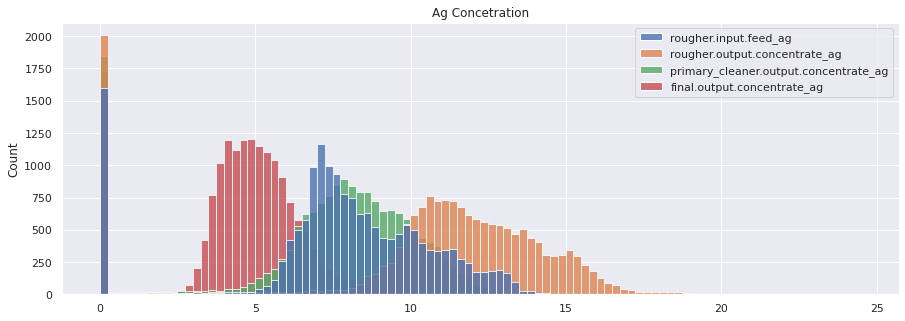

In [31]:
fig, ax1 = plt.subplots(figsize=(15,5))
sns.histplot(data=data_ag,alpha=.8)
ax1.set_title('Ag Concetration')


In [32]:
data_au = data_train[['rougher.input.feed_au','rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]

Text(0.5, 1.0, 'Au Concetration')

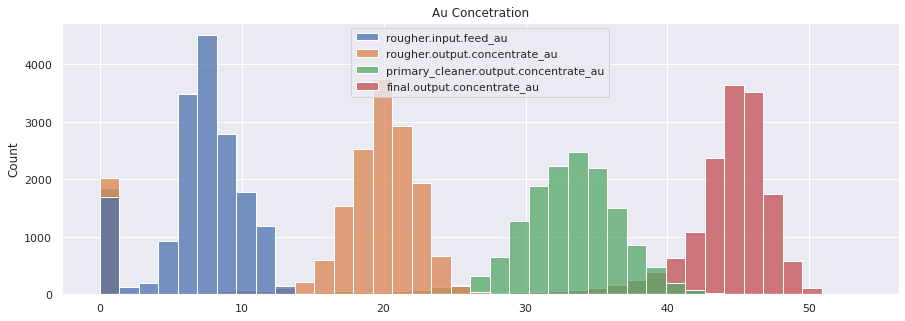

In [33]:
fig, ax2 = plt.subplots(1,figsize=(15,5))
sns.histplot(data=data_au)
ax2.set_title('Au Concetration')


In [34]:
data_pb = data_train[['rougher.input.feed_pb','primary_cleaner.output.concentrate_pb','rougher.output.concentrate_pb','final.output.concentrate_pb']]

Text(0.5, 1.0, 'Pb Concetration')

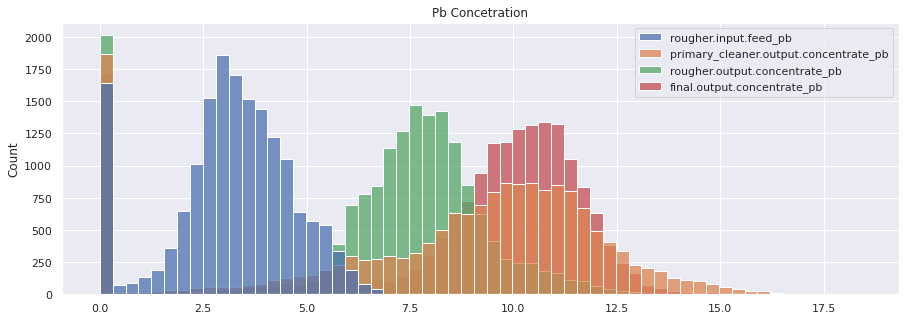

In [35]:
fig, ax3 = plt.subplots(1,figsize=(15,5))
sns.histplot(data=data_pb,ax=ax3)
ax3.set_title('Pb Concetration')


1. Концентрация серербра Ag 

Уровень серебра заметно уменьшается после второй очистики. Среднее значение уменьшается. На графике видно как после каждого этапа график смещается в лево.
2. Концентрация золота Au

Гистограмма золота как и серебра показывает изменения. Средний показатель увеличился, от этого график значительно сместился вправо. Разброс значений уменьшился. Это говорит о том, что доля золота в концентрате увеличивается на каждом этапе процеса очистки.

3. Свенец Pb
Гистограмма сместилась вправо, разброс данных немного уменьшился. Но из-за того что график сдвинулся вправо, похоже, что доля свенца в концентрате увеличилась, вероятно это из-за технологии флотации.


Еще на всех трех графиках есть пики на нулевых значениях. Это не похоже на истинные данные. Нулевые значения больше похожи на ошибки измерения или их отсутвие, возможно стоит от них мзбавится.

<div class="alert alert-block alert-info">
<b>Совет: </b> Гистограммы получились неплохо, но я бы сделал из полупрозрачными: параметр "alpha".
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Поигрался с прозрачностью, оставил в первом графике. В целом думаю надо цвета подобрать другие.
</div>

# 2.2 Сравнение размеров гранул сырья

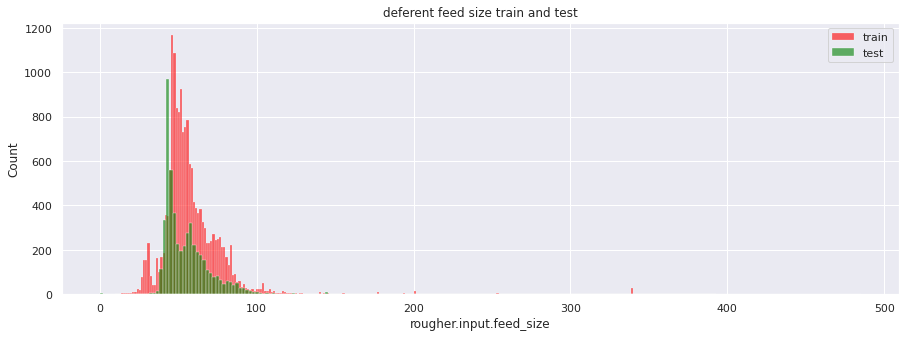

In [36]:
fig, ax4 = plt.subplots(1,figsize=(15,5))
sns.histplot(data_train['rougher.input.feed_size'],label='train',color='red',alpha=0.6)
sns.histplot(data_test['rougher.input.feed_size'],label='test',color='green',alpha=0.6)
ax4.set_title('deferent feed size train and test')
ax4.legend()

Распределение значения размера гранул  на обучающем и тестовом наборах данных схожи между собой

# 2.3. Исследования суммарной концентрации всех веществ на разных стадиях

У нас есть три стадии обработки сырья.


1.   Первая стадия - обогощение, флотация. Итог - черновой концентрат
2.   Вторая стадия - первый этап очистки. Итог - очищеный концентрат
3.   Третья стадия - второй этап очистки. Итог - финальный концентрат 

Вычислим для каждой стадии суммарное значение и построим  гистограмму и боксплот.


In [37]:
stage_concentration = pd.DataFrame(columns = ['input','rougher','primary','final'])

In [38]:
data_train['rougher_sum'] = data_train['rougher.output.concentrate_pb'] +\
                    data_train['rougher.output.concentrate_ag'] +\
                    data_train['rougher.output.concentrate_au'] +\
                    data_train['rougher.output.concentrate_sol']

In [39]:
data_train['primary_sum'] = data_train['primary_cleaner.output.concentrate_pb'] +\
                    data_train['primary_cleaner.output.concentrate_ag'] +\
                    data_train['primary_cleaner.output.concentrate_au'] +\
                    data_train['primary_cleaner.output.concentrate_sol']

In [40]:
data_train['final_sum'] = data_train['final.output.concentrate_pb'] +\
                    data_train['final.output.concentrate_ag'] +\
                    data_train['final.output.concentrate_au'] +\
                    data_train['final.output.concentrate_sol']

In [41]:
data_train['input_sum'] = data_train['rougher.input.feed_pb'] +\
                    data_train['rougher.input.feed_ag'] +\
                    data_train['rougher.input.feed_au'] +\
                    data_train['rougher.input.feed_sol']

In [42]:
stage_concentration = data_train.loc[:,['input_sum','rougher_sum','primary_sum','final_sum']]

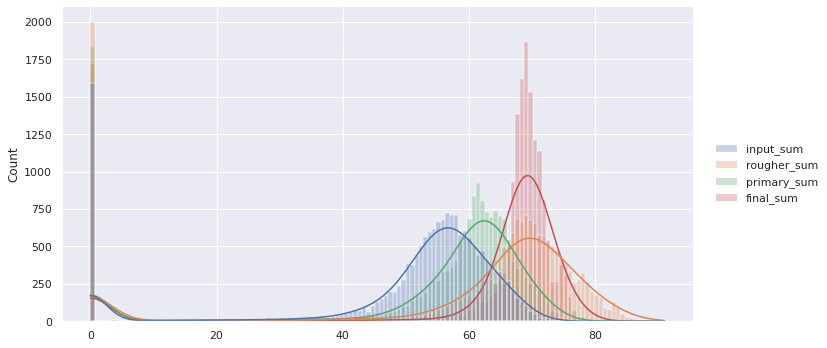

In [43]:
sns.displot(data=stage_concentration, aspect=2, kde=True, alpha = 0.3)

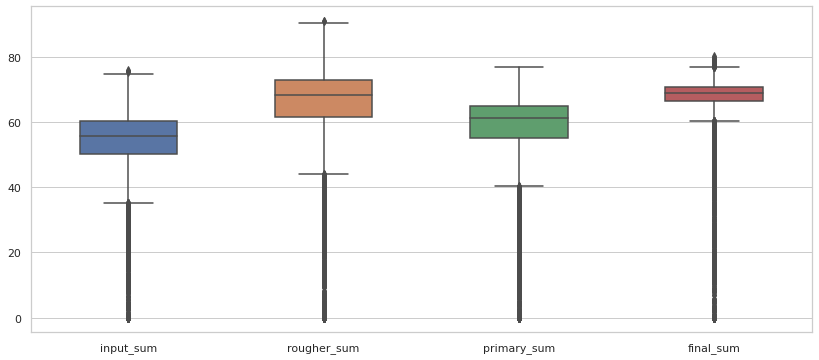

In [44]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
sns.boxplot(data=stage_concentration,width=0.5)

На графике очень хорошо видно "свечку" с нулевыми или близкими к 0 показателями, как следствие ошибок при занесении данных или их отсутсвии. Такие данны для нас бесполезны, придется удалить.

Удалим все выбросы. Так как на каждом этапе происходит измерение результата этапа и внесение данных, некорректные значения будем удалять для каждого этапа. Порог будет 0.1, соответсвенно если на одном из этапов сумарное значение концентрата веществ меньше или равно 0.1 для нас это будет означать, что на данном этапе были внесены не корректные данные.

In [45]:
data_train.drop(data_train.loc[data_train['rougher_sum'] <=0.1].index,inplace=True)
data_train.drop(data_train.loc[data_train['primary_sum'] <= 0.1].index,inplace=True)
data_train.drop(data_train.loc[data_train['final_sum'] <= 0.1].index,inplace=True)
data_train.drop(data_train.loc[data_train['input_sum'] <= 0.1].index,inplace=True)

In [46]:
len(data_train)

14362

In [47]:
(16860-14362)/16860

0.14816132858837486

In [48]:
stage_concentration = data_train.loc[:,['input_sum','rougher_sum','primary_sum','final_sum']]

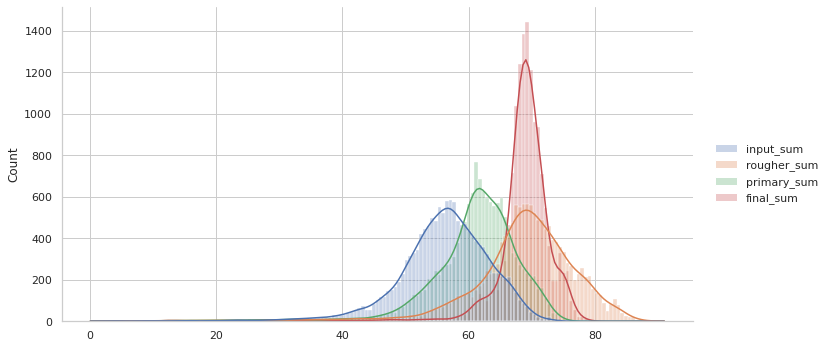

In [49]:
sns.displot(data=stage_concentration, aspect=2, kde=True, alpha = 0.3)



После удаление нулевых строк, выброс стал гораздо меньше, но и данных уже тоже меньше). Нам пришлось удалить 15 % данных


# 3. Построение модели.

Функция подсчета sMAPE.

Для опеределения лучшей модели будем использовать эту функцию. Данная метрика покажет нам процент ошибок в предсказания модели. Идеальным показателем для модели бедт значение 0 

In [50]:
def smape_final(p, t):
     return 1/len(p) * (sum((2*abs(t - p))*100 / (abs(p) + abs(t))))

In [51]:
def smape(y_true,y_predict):
  if len(y_true) != len(y_predict):
    return "разная длина массивов"
  
  result_rougher = smape_final(y_true['rougher.output.recovery'],y_predict[:,0])
  result_final = smape_final(y_true['final.output.recovery'],y_predict[:,1])
  

  result = (0.25*result_rougher + 0.75*result_final)
  return result

# Подготовим наборы для обучения



1.   Для начала подгтовим тестовы набор данных, затем по нему определим признаки для тренировочного.





In [52]:
data_train.isna().mean().nlargest(15)

final.output.concentrate_ag              0.0
final.output.concentrate_pb              0.0
final.output.concentrate_sol             0.0
final.output.concentrate_au              0.0
final.output.recovery                    0.0
final.output.tail_ag                     0.0
final.output.tail_pb                     0.0
final.output.tail_sol                    0.0
final.output.tail_au                     0.0
primary_cleaner.input.sulfate            0.0
primary_cleaner.input.depressant         0.0
primary_cleaner.input.feed_size          0.0
primary_cleaner.input.xanthate           0.0
primary_cleaner.output.concentrate_ag    0.0
primary_cleaner.output.concentrate_pb    0.0
dtype: float64

In [53]:
data_train = shuffle(data_train)

In [54]:
data_test = shuffle(data_test)

In [55]:
x_test = data_test.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
y_test = data_test[['rougher.output.recovery','final.output.recovery']]

In [56]:
# подготовка тренеровочного набора.
x_train = data_train[x_test.columns]
y_train = data_train[['rougher.output.recovery','final.output.recovery']]

In [57]:
len(y_train)

14362

Обучать будем три модели
MultiOutputRegressor и RandomForestRegressor Treedesigen.




Линейная регрессия

In [58]:
lr  = MultiOutputRegressor(LinearRegression(normalize=True))
lr.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=True),
                     n_jobs=None)

In [59]:
predict_lr = lr.predict(x_train)

In [60]:
smape(y_train,predict_lr)

7.620775552632167

Модель случайный лес

In [61]:
gyperparams = [{'n_estimators': range(1,50,10),'max_depth': range(1,40,10)}]
clf = RandomForestRegressor(random_state=12345)

In [62]:
#  так как наша задача минимизировать показатель smape, будем использовать параметр greater_is_better = False
grid = GridSearchCV(clf,gyperparams,scoring=make_scorer(smape,greater_is_better=False),cv=3)

In [63]:

%time grid.fit(x_train,y_train)

CPU times: user 8min 9s, sys: 233 ms, total: 8min 9s
Wall time: 8min 11s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_sta

In [64]:
grid.best_score_ *-1

5.421992198974851

In [65]:
grid.best_params_

{'max_depth': 31, 'n_estimators': 41}

Модель решающее дерево

In [66]:
gyperparams_tr = [{'max_depth': range(1,40,10)}]
tr = RandomForestRegressor(random_state=12345)

In [67]:
grid_tr = GridSearchCV(tr, gyperparams_tr, scoring=make_scorer(smape,greater_is_better=False),cv=3)

In [68]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%time grid_tr.fit(x_train,y_train)

CPU times: user 8min 37s, sys: 276 ms, total: 8min 38s
Wall time: 8min 39s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_sta

In [69]:
grid_tr.best_score_ *-1

5.322979468079908

In [70]:
grid_tr.best_params_

{'max_depth': 31}

Лучше всего показатель оказался у модели решабщего дерева и случайного леса. Несмотря на то что они трицательные.

Проверим эти модели с полученными параметрами на тестовой выборке.

Случайнй лес

In [71]:
model_rf = RandomForestRegressor(n_estimators=41,max_depth=31,random_state=12345)

In [72]:
model_rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=31, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=41, n_jobs=None, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

In [73]:
predicted_rf = model_rf.predict(x_test)

In [74]:
smape(y_test, predicted_rf)

10.535759924237547

Решающее дерево

In [75]:
model_tr = DecisionTreeRegressor(max_depth=41, random_state=12345)

In [76]:
model_tr.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=41,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=12345, splitter='best')

In [77]:
predicted_tr = model_tr.predict(x_test)

In [78]:
smape(y_test, predicted_tr)

16.513851489619473

# Итог
Модели обучены, предсказания получены, эффетивность обогощения расчитана расчитана.

Полученный набор данных был с множеством неточностей, большим колличеством пропусков на разных этапах процесса очистки. В дальнейшем для улучшения модели необходимо более тчательно подходить к процессу измерения на всех стадиях обработки сырья.
Для обучения модели нам пришлось избавится от 15% процентов данных. 

Тестировались три модели Линейная регрессия, случайный лес и дерево решений.
Для моделей решабщее дерево и случайный лес подбор параметров производился с помощью gridsearchCV и кросс-валидации с 3-мя наборами.
По итогам была выбраны две лучшие модели Случайный лес и решающее дерево, на тестовой выборке лучший показатель у модели решающее дерево, отклонение 10 %



